In [1]:
import os
import copy 
import numpy as np
import re
import json
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from pathlib import Path
from typing import Optional, List
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from pydantic_settings import BaseSettings, SettingsConfigDict
from langchain.output_parsers import PydanticOutputParser

from langchain.prompts import PromptTemplate
from langchain.chat_models import init_chat_model
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

import random
import itertools
seed = 42
random.seed(seed)

In [2]:
def load_env():
	env_file_path = ".env"
	if os.path.exists(env_file_path):
		load_dotenv(env_file_path, override=True)
		print("Loaded environment variables")
	else:
		print(f"Error: .env file not found at {env_file_path}")

load_env()


class ModelSettings(BaseSettings):
	model: str
	temperature: Optional[float] = 0
	max_tokens: Optional[int] = None

class ProcessModelSettings(BaseSettings):
	embedding: ModelSettings
	gpt4o: ModelSettings
	phi4: ModelSettings
	deepseek: ModelSettings
	o1: ModelSettings


class Settings(BaseSettings):
	model_config = SettingsConfigDict(env_file=".env", env_nested_delimiter="__")

	# Keys
	azure_openai_api_key: Optional[str]
	azure_openai_endpoint: Optional[str]
	openai_api_version: Optional[str]

	openai_api_deployment_name_gpt4_vision_no_filters: Optional[str]
	openai_vision_api_version_gpt4_vision_no_filters: Optional[str]
	openai_api_key_gpt4_vision_no_filters: Optional[str]
	openai_base_url_gpt4_vision_no_filters: Optional[str]

	# models
	processmodel: ProcessModelSettings


settings = Settings()

Loaded environment variables


### Extract chapter and criteria

In [3]:
def extract_chapter_title(content):
    pattern = r"^#\s*(.+)$"
    for i, line in enumerate(content.split("\n"), start=1):
        match = re.match(pattern, line)
        if match:
            return match.group(1).strip()
    return ""

def get_criteria_chapter(text):
    criteria_pattern = r"^-\s*(Critical|Urgent|Normal)\s*\|\s*([^|\n]+)(?:\|\s*([^|\n]+))?$"
    matches = re.findall(criteria_pattern, text, flags=re.MULTILINE)
    criteria_list = []
    for _, situation, _ in matches:
        situation = situation.strip()
        # Remove useless situation/advices
        if "other, not urgent" in situation.lower() or "other symptoms related to this page" in situation.lower():
            continue
        criteria_list.append(situation)
    return criteria_list

### Extract combinations for validation and testing

In [4]:
def extract_eval_combos(dataset):
	grouped_by_chapter = defaultdict(list)
	for entry in dataset:
		criteria = entry[0]["content"]
		advices = entry[1]["original_advices"]
		chapter = entry[1]["chapter"]
		grouped_by_chapter[chapter].append({"criteria": criteria, "advices": advices, "chapter": chapter})

	def get_combo(dataset, k):
		
		chapter_samples = []
		for chapter, items in grouped_by_chapter.items():
			combinations = list(itertools.combinations(items, k))
			random.shuffle(combinations)
			chapter_samples.append(combinations)

		total_combos = sum(len(combos) for combos in chapter_samples)
		max_combos_to_sample = len(dataset) // 2

		combo_k = []
		if total_combos <= max_combos_to_sample:
			combo_k = [combo for sublist in chapter_samples for combo in sublist]
		else:
			max_iter = max(len(samples) for samples in chapter_samples)
			for i in range(max_iter):
				for samples in chapter_samples:
					if len(combo_k) >= max_combos_to_sample:
						break
					if i < len(samples):
						combo_k.append(samples[i])

		return combo_k

	combo2 = get_combo(dataset, 2)
	combo3 = get_combo(dataset, 3)
	combo = combo2 + combo3
	random.shuffle(combo)

	return combo

### Combine advices and remove duplicates

In [5]:
def clean_text(text):
	return text.replace("–","-").replace("•", "-").replace("’","'")


def get_advice_list(text):
	advice_pattern = r"Advice\s*(\d+)\.\s*([^\n]+)\n([\s\S]+?)(?=Advice\s*\d+\.\s*[^\n]+\n|\Z)"
	matches = re.findall(advice_pattern, text.strip())
	Advices = []
	for i, match in enumerate(matches):
		if i == 0:
			advice_title = f"{match[1].strip()}\n"
		else:
			advice_title = f"\n{match[1].strip()}\n"
		Advices.append((advice_title,match[2].strip()))
	return Advices


def get_unique_advices(labeled_chapters: List[str], advices: List[str]):
	cleaned_advice_list = [advice.replace("### ","").replace("## ","") for advice in advices]
	combined_advices = [get_advice_list(advice.strip()) for advice in cleaned_advice_list]

	unique_chapters = set(set(labeled_chapters))
	advice_set = set()
	chapter_advices = []
	for chapter, advice_list in zip(labeled_chapters, combined_advices):
		temp_advices = []
		for i, advice_tuple in enumerate(advice_list):
			advice_title = "\n## " + advice_tuple[0].strip() + "\n"
			advice = advice_tuple[1]

			if advice.strip() in advice_set:
				continue
			temp_advices.append(advice_title+advice)
			advice_set.add(advice.strip())

		if temp_advices:
			if len(unique_chapters) > 1:
				temp_advices.insert(0, f"\n# Chapter: {chapter}")
			chapter_advices.append("\n".join(temp_advices))

	relevant_chapters = "# Relevant Chapters: \n- " + "\n- ".join(unique_chapters) + "\n"
	return relevant_chapters + "\n".join(chapter_advices)


labeled_chapters = ['32 Seizures (convulsions, fits)']
# Relevant Chapters:\n- 32 Seizures asdasd (convulsions, fits)\n\nAdvice 1. IMPORTANT INFORMATION TO THE CALLER\n- Help is on the way. I may need to phone you back, so keep this phone free until the\nmedics arrive.\n- Watch the person all the time. Tell me immediately if anything changes.\n\nAdvice 2. MEDICATION\n- Any medication being used by the person must accompany them at all times.\n- If the person has medication for seizures / convulsions, you can give it before the medics arrive.\n\nAdvice 5. WHEN THE CONVULSIONS STOP\n- Make sure the airway is free and the person is breathing normally.\n- Lay the person on his / her side.\n- Keep warm with blankets (or clothing) over and under the person, and keep the person in a sheltered area.', '# Relevant Chapters:\n- 32 Seizures (convulsions, fits)\n\nAdvice 1. IMPORTANT INFORMATION TO THE CALLER\n- Help is on the way. I may need to phone you back, so keep this phone free until the\nmedics arrive.\n- Watch the person all the time. Tell me immediately if anything changes.\n\nAdvice 2. MEDICATION\n- Any medication being used by the person must accompany them at all times.\n- If the person has medication for seizures / convulsions, you can give it before the medics arrive.\n\nAdvice 5. WHEN THE CONVULSIONS STOP\n- Make sure the airway is free and the person is breathing normally.\n- Lay the person on his / her side.\n- Keep warm with blankets (or clothing) over and under the person, and keep the person in a sheltered area.', '# Relevant Chapters:\n- 32 Seizures (convulsions, fits)\n\nAdvice 1. IMPORTANT INFORMATION TO THE CALLER\n- Help is on the way. I may need to phone you back, so keep this phone free until the\nmedics arrive.\n- Watch the person all the time. Tell me immediately if anything changes.\n\nAdvice 2. MEDICATION\n- Any medication being used by the person must accompany them at all times.\n- If the person has medication for seizures / convulsions, you can give it before the medics arrive.\n\nAdvice 3. ONGOING SEIZURE\n- Make sure the person doesn’t come to any harm.\n- Put something soft under his / her head, loosen tight clothing.\n- Do not put anything in the mouth or between the teeth.\n\nAdvice 4. DIFFICULTY BREATHING\n- Try to create calm around the person, loosen tight clothing.\n- Help the person to sit up / find a comfortable position.\n- Observe breathing.\n\nIf the person can’t sit up:\n- Lay the person on one side.\n- Gently tilt the head back and lift the chin forwards.\n\nInfant under 1 year:\n- Keep the head in a neutral position and lift the chin forwards.\n- Observe breathing, tell me if there is any change.']
test_advices = ["# Relevant Chapters:\n- 09 Scuba diving accident\n\nAdvice 1. IMPORTANT INFORMATION TO THE CALLER\n- Help is on the way. I may need to phone you back, so keep this phone free until the medics arrive.\n- Watch the casualty all the time. Tell me immediately if anything changes.\n\nNB!\n- Take care of all valves and tanks.\n- You need to send the diver's log, depth gauge and dive computer with the casualty if possible.\n\nAdvice 2. SAFETY AT THE SCENE\n- Keep out of danger and always ensure the safety of others.\n- If possible and without risk, get the casualties to safety.\n- Try to get an overall picture and give me more information as soon as you can.\n\nAdvice 5. AVOID ALL LOSS OF HEAT\n- Remove wet clothes and wrap the casualty in dry blankets or dry clothes - use as many as you can.\n- Place an insulating layer under him / her if possible.\n- Try to create shelter from the elements (weather / wind), go indoors if possible.\n\nLIFE-SAVING FIRST AID FOR HYPOTHERMIA\n\nCold casualty barely responsive / unresponsive:\n- Make sure the airway is free and take 60 seconds to check if the casualty is breathing.\n- If s/he is breathing normally, place flat in the recovery position.\n- Check breathing at regular intervals (every minute).\n- Avoid any abrupt movements or changes in the casualty's position, this could lead to cardiac arrest.\n\nAvoid any more heat loss:\n- As soon as insulating, windproof textiles are available to wrap the casualty in, cut away all wet clothing. Alternatively, leave the casualty in the wet clothes and pack him/her in windproof / steam proof textiles.\n- If possible, get the casualty to a sheltered place, preferably indoors in a warm room.\n\nFully alert, unharmed casualties:\n- Give plenty of warm, sugary drink (non- alcoholic).\n- Do not rub the affected areas.\n- Give oxygen if obtainable.\n- Take the casualty's temperature if you have a thermometer, and it is practical to do so.\n\nAdvice 7. IF SYMPTOMS AFTER A DIVE\n- Give 100 % oxygen if available.\n- Preferably 10L / min. in an anesthetic facemask (or an O2 diving regulator)."]
res =  get_unique_advices(labeled_chapters, test_advices)
print(res)

# Relevant Chapters: 
- 32 Seizures (convulsions, fits)

## IMPORTANT INFORMATION TO THE CALLER
- Help is on the way. I may need to phone you back, so keep this phone free until the medics arrive.
- Watch the casualty all the time. Tell me immediately if anything changes.

NB!
- Take care of all valves and tanks.
- You need to send the diver's log, depth gauge and dive computer with the casualty if possible.

## SAFETY AT THE SCENE
- Keep out of danger and always ensure the safety of others.
- If possible and without risk, get the casualties to safety.
- Try to get an overall picture and give me more information as soon as you can.

## AVOID ALL LOSS OF HEAT
- Remove wet clothes and wrap the casualty in dry blankets or dry clothes - use as many as you can.
- Place an insulating layer under him / her if possible.
- Try to create shelter from the elements (weather / wind), go indoors if possible.

LIFE-SAVING FIRST AID FOR HYPOTHERMIA

Cold casualty barely responsive / unresponsive:
- Ma

### Distribution of atomic advices
- A criteria is made up of a set of 1 or more atomic advices concatenated

In [6]:
def get_atomic_advices_uid(atomic_advices, text):
	advice_pattern = r"Advice\s*(\d+)\.\s*([^\n]+)\n([\s\S]+?)(?=Advice\s*\d+\.\s*[^\n]+\n|\Z)"
	matches = re.findall(advice_pattern, text.strip())
	for i, match in enumerate(matches):
		atomic_advices.append(match[2].strip())

def get_atomic_advices(atomic_advices, text):
	pattern = re.compile(r"##\s*(.*?)\n(.*?)(?=\n##|\Z)", re.DOTALL)
	matches = pattern.findall(text)
	for _, content in matches:
		atomic_advices.append(content.strip())

def plot_atomic_advices(count_advices, k=3):
	counts = [c for _, c in count_advices.most_common()]
	N = len(counts)

	plt.figure(figsize=(11,6))
	bars = plt.bar(range(N), counts, color='lightsteelblue', width=0.8)

	for i in range(k):
		bars[i].set_color('royalblue')
		bars[i].set_edgecolor('navy')
		bars[i].set_linewidth(1.5)

	# Grid and spines
	plt.grid(axis='y', linestyle='--', alpha=0.5)
	for side in ['top','right']:
		plt.gca().spines[side].set_visible(False)

	# Bigger ticks
	plt.tick_params(axis='both', which='major', labelsize=12, length=6)

	# Use log scale if you like
	# plt.yscale('log')
	# plt.ylabel("Count (log scale)", fontsize=14)

	plt.xlabel("Advice index (ordered)", fontsize=14)
	plt.ylabel("Count", fontsize=14)
	plt.title('Frequency of Atomic Advices', fontsize=16, fontweight='bold', pad=20)

	# Inset with top-3 text
	inset = plt.axes([0.2, 0.5, 0.3, 0.35])  # [left, bottom, width, height]
	inset.axis('off')
	topk = count_advices.most_common(k)


	def boldify(text):
		print(text)
		text = text.split(" ")
		return " ".join([r"$\bf{" + word + "}$" for word in text])

	streng = ""
	for i, (text, count) in enumerate(topk):
		streng += f"\n\n{boldify(f'Advice {i+1}. (frequency: {count} times)')}\n{text}"

	inset.text(0, 0.8,  f"Top {k} most common advices:", fontsize=14, weight='bold')
	plt.gcf().text(0.2, 0.8, streng, fontsize=11, va='top', ha='left', linespacing=1.75)

	plt.tight_layout()

	plt.savefig("AtomicAdvice.pdf", format="pdf")  

	plt.show()


In [7]:
test = []

text = """
# Relevant Chapters: 
- 32 Seizures (convulsions, fits)

## IMPORTANT INFORMATION TO THE CALLER
- Help is on the way. I may need to phone you back, so keep this phone free until the medics arrive.
- Watch the casualty all the time. Tell me immediately if anything changes.

NB!
- Take care of all valves and tanks.
- You need to send the diver's log, depth gauge and dive computer with the casualty if possible.

## SAFETY AT THE SCENE
- Keep out of danger and always ensure the safety of others.
- If possible and without risk, get the casualties to safety.
- Try to get an overall picture and give me more information as soon as you can.

## AVOID ALL LOSS OF HEAT
- Remove wet clothes and wrap the casualty in dry blankets or dry clothes - use as many as you can.
- Place an insulating layer under him / her if possible.
- Try to create shelter from the elements (weather / wind), go indoors if possible.

LIFE-SAVING FIRST AID FOR HYPOTHERMIA

Cold casualty barely responsive / unresponsive:
- Make sure the airway is free and take 60 seconds to check if the casualty is breathing.
- If s/he is breathing normally, place flat in the recovery position.
- Check breathing at regular intervals (every minute).
- Avoid any abrupt movements or changes in the casualty's position, this could lead to cardiac arrest.

Avoid any more heat loss:
- As soon as insulating, windproof textiles are available to wrap the casualty in, cut away all wet clothing. Alternatively, leave the casualty in the wet clothes and pack him/her in windproof / steam proof textiles.
- If possible, get the casualty to a sheltered place, preferably indoors in a warm room.

Fully alert, unharmed casualties:
- Give plenty of warm, sugary drink (non- alcoholic).
- Do not rub the affected areas.
- Give oxygen if obtainable.
- Take the casualty's temperature if you have a thermometer, and it is practical to do so.

## IF SYMPTOMS AFTER A DIVE
- Give 100 % oxygen if available.
- Preferably 10L / min. in an anesthetic facemask (or an O2 diving regulator).
"""

get_atomic_advices(test, text)
test

["- Help is on the way. I may need to phone you back, so keep this phone free until the medics arrive.\n- Watch the casualty all the time. Tell me immediately if anything changes.\n\nNB!\n- Take care of all valves and tanks.\n- You need to send the diver's log, depth gauge and dive computer with the casualty if possible.",
 '- Keep out of danger and always ensure the safety of others.\n- If possible and without risk, get the casualties to safety.\n- Try to get an overall picture and give me more information as soon as you can.',
 "- Remove wet clothes and wrap the casualty in dry blankets or dry clothes - use as many as you can.\n- Place an insulating layer under him / her if possible.\n- Try to create shelter from the elements (weather / wind), go indoors if possible.\n\nLIFE-SAVING FIRST AID FOR HYPOTHERMIA\n\nCold casualty barely responsive / unresponsive:\n- Make sure the airway is free and take 60 seconds to check if the casualty is breathing.\n- If s/he is breathing normally, pla

### Define chapters to extract and validation/test split

In [8]:
start_index = 2
end_index = -2
exclude = np.array([21, 36])
exclude-=1

validation = 0.1
test = 0.1

### Load paraphrase dataset

In [10]:
paraphrase_source_path = "Data/Json/Paraphrase/"
paraphrase_paths = [os.path.join(paraphrase_source_path, file) for file in os.listdir(paraphrase_source_path) if file.startswith("Chap")]
paraphrase_paths.sort()

resolved_end = len(paraphrase_paths) + end_index if end_index < 0 else end_index
indices = [i for i in range(start_index, resolved_end) if i not in exclude.tolist()]
paraphrase_paths = [paraphrase_paths[i] for i in indices]
paraphrase_paths

['Data/Json/Paraphrase/Chap_03.jsonl',
 'Data/Json/Paraphrase/Chap_04.jsonl',
 'Data/Json/Paraphrase/Chap_05.jsonl',
 'Data/Json/Paraphrase/Chap_06.jsonl',
 'Data/Json/Paraphrase/Chap_07.jsonl',
 'Data/Json/Paraphrase/Chap_08.jsonl',
 'Data/Json/Paraphrase/Chap_09.jsonl',
 'Data/Json/Paraphrase/Chap_10.jsonl',
 'Data/Json/Paraphrase/Chap_11.jsonl',
 'Data/Json/Paraphrase/Chap_12.jsonl',
 'Data/Json/Paraphrase/Chap_13.jsonl',
 'Data/Json/Paraphrase/Chap_14.jsonl',
 'Data/Json/Paraphrase/Chap_15.jsonl',
 'Data/Json/Paraphrase/Chap_16.jsonl',
 'Data/Json/Paraphrase/Chap_17.jsonl',
 'Data/Json/Paraphrase/Chap_18.jsonl',
 'Data/Json/Paraphrase/Chap_19.jsonl',
 'Data/Json/Paraphrase/Chap_20.jsonl',
 'Data/Json/Paraphrase/Chap_22.jsonl',
 'Data/Json/Paraphrase/Chap_23.jsonl',
 'Data/Json/Paraphrase/Chap_24.jsonl',
 'Data/Json/Paraphrase/Chap_25.jsonl',
 'Data/Json/Paraphrase/Chap_26.jsonl',
 'Data/Json/Paraphrase/Chap_27.jsonl',
 'Data/Json/Paraphrase/Chap_28.jsonl',
 'Data/Json/Paraphrase/Ch

### Split Paraphrase dataset

In [11]:
paraphrase_by_uid = defaultdict(list)
for i, path in enumerate(paraphrase_paths):
	with open(path, "r", encoding="utf-8") as f:
		for line in f:
			json_obj = json.loads(line.strip()) 
			Entry = json_obj.get("entry")
			if not Entry:
				continue
			
			uid = Entry[0]["uuid"]
			criteria = clean_text(Entry[0]["content"])
			chapter = clean_text(Entry[1]["content"])
			advices = clean_text(Entry[1]["advices"])
	
			# Remove advice numbers
			cleaned_advices = re.sub(r"\n\nAdvice \d+\. ", "\n\n## ", advices)
			transformed_entry = [
				{"role": "user", "content": criteria},
				{"role": "assistant","content": cleaned_advices, "chapter": chapter, "original_advices": advices},
			]
			paraphrase_by_uid[uid].append(transformed_entry)


# Split into held-out and retained sets
paraphrase_train = []
paraphrase_val = []
paraphrase_test = []

for uid, entries in paraphrase_by_uid.items():
	n = len(entries)
	if n == 1:
		paraphrase_train.extend(entries)
	else:
		extract_n_val = int(np.floor(n * validation))
		extract_n_test = int(np.floor(n * test))

		# Assign entries to validation and test sets (ensure we prioritize validation and test)
		if extract_n_val + extract_n_test < n:
			paraphrase_val.extend(entries[:extract_n_val])
			paraphrase_test.extend(entries[extract_n_val:extract_n_val + extract_n_test])
			paraphrase_train.extend(entries[extract_n_val + extract_n_test:])
		else:
			# If not enough entries for both validation and test, adjust accordingly
			paraphrase_val.extend(entries[:extract_n_val])
			paraphrase_test.extend(entries[extract_n_val:])
			paraphrase_train.extend([])


random.shuffle(paraphrase_train)
random.shuffle(paraphrase_val)
random.shuffle(paraphrase_test)

print(f"Training: {len(paraphrase_train)} entries")
print(f"Validation: {len(paraphrase_val)} entries")
print(f"Test: {len(paraphrase_test)} entries")

Training: 5680 entries
Validation: 568 entries
Test: 568 entries


In [12]:
paraphrase_train[0]

[{'role': 'user',
  'content': 'exhibited seizure symptoms, no record of febrile convulsions, minor'},
 {'role': 'assistant',
  'content': '# Relevant Chapters:\n- 16 Child / infant - illness\n\n## MEDICATION\n- Any medication being used by the child must accompany them at all times.\n\n## FEVER See 32 Seizures on suspicion of febrile seizures\n- Undress the child and, if necessary, cool him / her down with a flannel dipped in tepid water\n- In a well-lit room - check the whole body carefully for a rash.\n- You may give fever-reducing medication like Paracetamol, follow the instructions on the packet.\n- Febrile infants under 3 months must always be checked by a doctor/GP.\n- NB! Premature babies with fever should be checked by a doctor up to 3 months after the estimated due date (EDD)',
  'chapter': '16 Child / infant - illness',
  'original_advices': '# Relevant Chapters:\n- 16 Child / infant - illness\n\nAdvice 2. MEDICATION\n- Any medication being used by the child must accompany t

### Combine 2 & 3 criteria within the same chapter

In [13]:
corpus_criteria = defaultdict(lambda: defaultdict(list))
for i, path in enumerate(paraphrase_paths):
	chapter_criteria = defaultdict(lambda: defaultdict(list))
	cur_uid = None
	cur_chapter = None
	with open(path, "r", encoding="utf-8") as f:
		for line in f:
			json_obj = json.loads(line.strip()) 
			Entry = json_obj.get("entry")
			if not Entry:
				continue

			uid = Entry[0]["uuid"]
			criteria = clean_text(Entry[0]["content"])
			chapter = clean_text(Entry[1]["content"])
			advices = clean_text(Entry[1]["advices"])

			if cur_chapter is None:
				cur_chapter = chapter
			if chapter != cur_chapter:
				raise ValueError(f"Chapter mismatch: {chapter} != {cur_chapter}")

			if cur_uid is None or cur_uid != uid:
				cur_uid = uid
				chapter_criteria[cur_uid]["criteria"] = criteria.strip()
				chapter_criteria[cur_uid]["advices"] = advices.strip()
				chapter_criteria[cur_uid]["chapter"] = chapter.strip()
			else:
				chapter_criteria[cur_uid]["paraphrases"].append(criteria.strip())

	corpus_criteria[cur_chapter] = chapter_criteria

count_test = defaultdict(int)

def generate_intra_combinations(corpus_criteria, k=2, entries=10_000) -> List:  
	seen_pairs = set()	
	def combo_generator():
		
		for entries_dict in corpus_criteria.values():
			chapter_entries = []
			for entry_obj in entries_dict.values():
				chapter_entries.append({
					"chapter": entry_obj["chapter"],
					"criteria": entry_obj["criteria"],
					"advices": entry_obj["advices"],
				})
			if len(chapter_entries) < k:
				continue

			count_test[entry_obj['chapter']] += len(chapter_entries)

			for combo in itertools.combinations(chapter_entries, k):
				combined_chapters = sorted([entry["chapter"].strip() for entry in combo])
				combined_criteria = sorted([entry["criteria"].strip() for entry in combo])
				combined_key = tuple(sorted((chapter, criteria) for chapter, criteria in zip(combined_chapters, combined_criteria)))
				if combined_key not in seen_pairs:
					seen_pairs.add(combined_key)
					yield combo

	combinations = list(combo_generator())
	print(f"Unique intra-chapter combinations of {k}: {len(combinations)}")
	random.shuffle(combinations)
	return combinations#[:entries]

combo2 = generate_intra_combinations(corpus_criteria,k=2)
#combo3 = generate_intra_combinations(corpus_criteria,k=3)
combinations = combo2 #+ combo3

atomic_advices_intra = []
for i, combination in enumerate(combinations):
	combined_chapters = [entry["chapter"].strip() for entry in combination]
	combined_criteria = [entry["criteria"].strip() for entry in combination]
	combined_advices = [entry["advices"].strip() for entry in combination]
	random.shuffle(combined_criteria)
	criteria_sample = ", ".join(combined_criteria)
	advices_sample = get_unique_advices(combined_chapters, combined_advices)
	get_atomic_advices(atomic_advices_intra, advices_sample)

Unique intra-chapter combinations of 2: 4785


In [14]:
combo2[0]

({'chapter': '26 Gynecology / pregnancy',
  'criteria': 'unresponsive female, altered consciousness, potential obstetric emergency',
  'advices': '# Relevant Chapters:\n- 26 Gynecology / pregnancy\n\nAdvice 1. IMPORTANT INFORMATION TO THE CALLER\n- Help is on the way. I may need to phone you back, so keep this phone free until the medics arrive.\n- Watch her all the time. Tell me immediately if anything changes.'},
 {'chapter': '26 Gynecology / pregnancy',
  'criteria': 'Gestational, 20 weeks plus - Mild uterine contractions, abdominal discomfort',
  'advices': '# Relevant Chapters:\n- 26 Gynecology / pregnancy\n\nAdvice 7. UNCLEAR SITUATION, MAY NEED AN OPERATION / ANAESTHETIC\n- Do not give her anything to eat or drink.\n\nAdvice 9. CONTACT THE NEAREST MATERNITY HOSPITAL IF RELEVANT\nAMK / LVS can connect the caller to the nearest maternity hospital and join in the call if necessary.'})

### Inspect distribution of atomic advices

In [ ]:
criteria = []
for uid, entries in paraphrase_by_uid.items():
	criteria.append([entries[0]["content"].lower().strip() for entries in entries])
	display(entries)
	break

In [ ]:
atomic_advices = []
for uid, entries in paraphrase_by_uid.items():
	advices = entries[0][1]["original_advices"]
	get_atomic_advices_uid(atomic_advices, advices)
plot_atomic_advices(Counter(atomic_advices), k=3)

### Inspect distribution of atomic advices

Advice 1. (frequency: 3558 times)
Advice 2. (frequency: 2481 times)
Advice 3. (frequency: 1457 times)


/tmp/ipykernel_26510/276228803.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


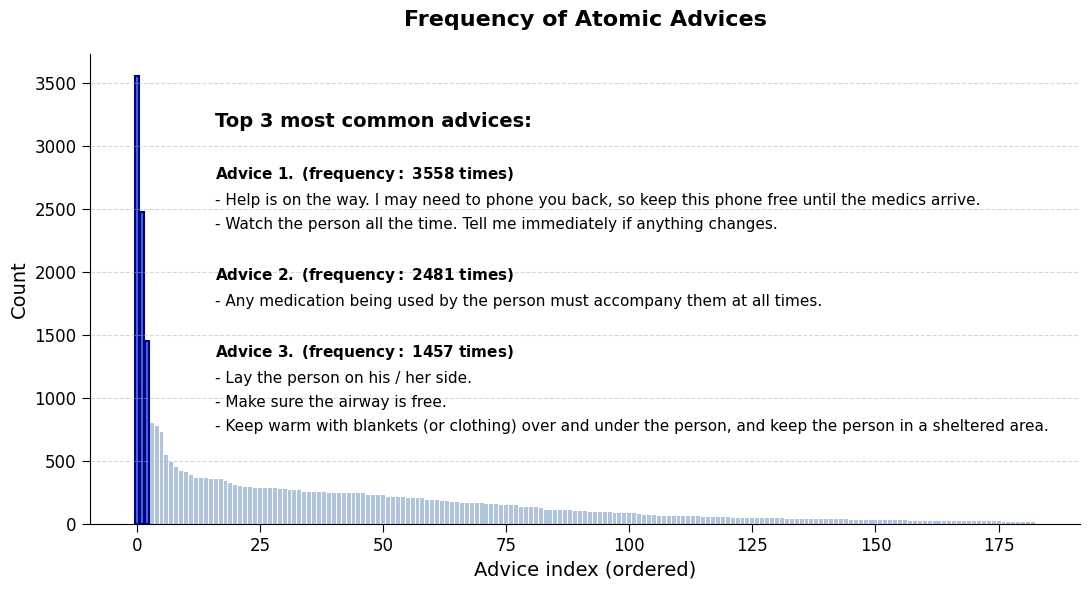

Total atomic advices: 34468


{"- Get the person to cough for as long as s/he is able.\n- A blockage in the throat will usually trigger a coughing reflex. Coughing can solve the problem and the object will dislodge and come up.\n- CHILDREN: Do not put your fingers in the child's mouth. Check if you can see the object and only remove the blockage if you can see it.": 7.809135398120538,
 "- Don't try to make the person sick.\n- Don't give him/her any food, drink or activated charcoa": 7.809135398120538,
 '- Local frostbite can be warmed skin to skin but must not be exposed to the cold afterwards.\n- Do not rub with snow or ice.\n- The casualty must be out of the cold before the frostbitten area can be reheated.\n- Severe frostbite should not be reheated before arrival at hospital.': 7.50389874124748,
 '- Do not drink while you are in pain.\n- Strong painkillers are often necessary if this is a kidney stone.\n- It often helps to drink large amounts, once the pain is over.': 7.4038732738758535,
 '- Do not provoke retch

In [49]:
# Count atomic advices
atomic_advices_paraphrase = []
for entry in paraphrase_train:
	criteria = entry[0]["content"]
	advices = entry[1]["content"]
	get_atomic_advices(atomic_advices_paraphrase, advices)

count_advices = Counter(atomic_advices_paraphrase) + Counter(atomic_advices_intra)
plot_atomic_advices(count_advices, k=3)

total_count = sum(count_advices.values())
print(f"Total atomic advices: {total_count}")

weights = {
    advice: float(np.log(1 + total_count / count))
    for advice, count in count_advices.items()
}

advice_weights = dict(sorted(weights.items(), key=lambda item: item[1], reverse=True))
advice_weights

#### Calculate the weight for class imbalance (log of inverse frequency) 

In [50]:
chapter_count = []
for i, entry in enumerate(paraphrase_train):
	chapter_count.append(entry[1]['chapter'])

for i, combination in enumerate(combinations):

	if len(set([entry["chapter"] for entry in combination])) != 1:
		raise Exception("Different chapters detected")

	chapter = combination[0]["chapter"]
	chapter_count.append(chapter)

chapter_count = Counter(chapter_count)
total = sum(chapter_count.values())
weights = {k: float(np.log(1 + total / count)) for k, count in chapter_count.items()}
chapter_weights = dict(sorted(weights.items(), key=lambda item: item[1], reverse=True))
chapter_weights

{'04 Choking / foreign object': 5.167164096328482,
 '03 Unconscious / decreased level of consciousness, breathing normally': 5.167164096328482,
 '31 Hypothermia / cold person': 4.292818489187455,
 '05 Mental health issue': 4.165489997435413,
 '27 Stroke symptoms': 4.047662389729965,
 '37 Urinary tract': 4.047662389729965,
 '23 Poisoning - not related to alcohol or drugs': 4.047662389729965,
 '30 Hyperthermia / heat stroke / heat exhaustion': 3.937934387212647,
 '08 Drowning': 3.937934387212647,
 '38 Ear, nose and throat': 3.937934387212647,
 '15 Allergic reaction': 3.937934387212647,
 '24 Functional decline': 3.8352074082599854,
 '29 Skin / rash': 3.738602889466367,
 '12 Major incident': 3.738602889466367,
 '17 Bite / insect sting': 3.738602889466367,
 '33 Breathing problems': 3.738602889466367,
 '20 Diabetes': 3.647406205907361,
 '09 Scuba diving accident': 3.647406205907361,
 '39 Eye': 3.647406205907361,
 '18 Bleeding - non-traumatic': 3.647406205907361,
 '14 Violence / abuse': 3.561

In [15]:
json_parser = JsonOutputParser()

structure_prompt = PromptTemplate(
    template="""
You will receive {num_descriptions} descriptions, each beginning with a bullet ("- ") and consisting of a "chapter" (enclosed between <start_chapter> and <end_chapter>) and a "situation" (enclosed between <start_situation> and <end_situation>).

### INSTRUCTIONS:
- The "Symptoms" field should contain only the symptoms and conditions, both mental and physical. Focus on observable or reported health issues.
- Include any stated demographic information (e.g., newborn, child, elderly, pregnant) as part of the cause if relevant.
- Ensure the result is medically realistic, detailed, and accurate.
- The "Cause" field should describe the direct reason for the event (e.g., trauma, illness, exposure). If missing, infer a medically sound and plausible cause based on the context.
- Use the "chapter" context only if the "situation" lacks enough medical or scenario-specific information on its own. Do not directly reuse chapter terms or their exact wording in the result.

### PARAPHRASING RULES:
- Significantly rephrase each result so it is not lexically or structurally similar to the input.
- Reword using completely different vocabulary and syntax. Avoid partial rewording, each sentence must be rewritten from the ground up with different phrasing.
- Reconstruct the sentence (e.g., merge/split clauses, change voice or order) while preserving meaning.
- Prioritize variety in expression across results while keeping the content medically faithful.
- Follow the exact format for each result and do not add, remove, or reorder fields.

### FORMAT:
For each result, use this structure:
Symptoms: …\\nCause: …

### DESCRIPTIONS:
{descriptions}

### IMPORTANT:
- Follow the "instructions", "paraphrase rules" and "format".
- Avoid using markdown or LaTeX formatting in the results.
- Return a JSON object with a key "Results" containing a list of {num_descriptions} result, each following the "format".

Response Format:
```json
{{
  "Results": [
    "Symptoms: ...\\nCause: ...",
    ...
  ]
}}
""",
    input_variables=["descriptions","num_descriptions"],
)


retries = 3

def generate_eval_test(chapter_list, criteria_list):

	descriptions = "- " + "\n- ".join(
		f"<start_chapter>{chapter}<end_chapter> <start_situation>{situation}<end_situation>"
		for chapter, situation in zip(chapter_list, criteria_list)
	)

	# Try with o1 model first
	for i in range(retries):
		try:
			llm = init_chat_model(**settings.processmodel.o1.model_dump(exclude_none=True))
			chain = structure_prompt | llm | StrOutputParser()
			response = chain.invoke({"descriptions": descriptions, "num_descriptions": len(criteria_list)})
			object = json_parser.parse(response.strip())

			if len(object["Results"]) != len(criteria_list):
				print(f"- Warning: Less than {len(criteria_list)} result generated. Retrying... ({i+1}/{retries})")
				continue
			
			return object["Results"]
		except Exception as e:
			print(f"- Error: {e}")
		finally:
			if llm is not None:
				del llm

	# Retry with gpt4o model
	print("- Warning: Retrying with gpt4o model...")
	try:
		llm = init_chat_model(**settings.processmodel.gpt4o.model_dump(exclude_none=True))
		chain = structure_prompt | llm | StrOutputParser()
		response = chain.invoke({"descriptions": descriptions, "num_descriptions": len(criteria_list)})
		object = json_parser.parse(response.strip())

		if len(object["Results"]) != len(criteria_list):
			raise Exception(f"Less than {len(criteria_list)} result generated.")
		
		return object["Results"]
	except Exception as e:
		print(f"- Error: {e}")
	finally:
		if llm is not None:
			del llm

	# Retry with deepseek model
	print("- Warning: Retrying with deepseek model...")
	try:
		llm = init_chat_model(**settings.processmodel.deepseek.model_dump(exclude_none=True))
		chain = structure_prompt | llm | StrOutputParser()
		cot_response = chain.invoke({"descriptions": descriptions, "num_descriptions": len(criteria_list)})
		response = re.sub(r"<think>.*?</think>", "", cot_response, flags=re.DOTALL).strip()
		object = json_parser.parse(response.strip())

		if len(object["Results"]) != len(criteria_list):
			raise Exception(f"Less than {len(criteria_list)} result generated.")

		return object["Results"]
	except Exception as e:
		print(f"- Error: {e}")
	finally:
		if llm is not None:
			del llm

	# Retry with phi4 model
	print("- Warning: Retrying with phi4 model...")
	try:
		llm = init_chat_model(**settings.processmodel.phi4.model_dump(exclude_none=True))
		chain = structure_prompt | llm | StrOutputParser()
		response = chain.invoke({"descriptions": descriptions, "num_descriptions": len(criteria_list)})
		object = json_parser.parse(response.strip())

		if len(object["Results"]) != len(criteria_list):
			raise Exception(f"Less than {len(criteria_list)} result generated.")
		return object["Results"]
	except Exception as e:
		print(f"- Error: {e}")
	finally:
		if llm is not None:
			del llm

	print("⚠️ WARNING: All models failed to generate results.")


criteria_list = [
    "Cranial trauma, recent onset of neurological deficits, Deep laceration, potential for sutures",
    "Expectant mother, 20 weeks gestation, experiencing malaise, elevated temperature, localized breast edema, Pregnant woman, experiencing contractions, gestational weeks 20 to 36",
    "Significant blood loss from traumatic injury, risk of hypothermia, decreased body temperature, exposure to cold, potential for frostbite"
]


chapter_list = ["11 Accident/Injury", "25 Childbirth", "32 Hypothermia"]
Results = generate_eval_test(chapter_list, criteria_list)

for i, item in enumerate(Results):
	print(item)
	print("="*50)


Symptoms: Head injury, new neurological impairments, severe cut requiring stitches.
Cause: Trauma from an accident leading to cranial damage.
Symptoms: Fatigue, increased body temperature, swelling in the breast area, experiencing contractions.
Cause: Pregnancy at 20 weeks with possible complications.
Symptoms: Severe blood loss, risk of body temperature dropping, exposure to cold conditions, potential for tissue damage from frostbite.
Cause: Traumatic injury resulting in significant hemorrhage and environmental exposure.


### Save paraphrased training data

In [ ]:
train_target_path = "Data/TrainData/paraphrase_dataset.jsonl"
with open(train_target_path, "w") as f_out:
	for transformed_entry in paraphrase_train:
		atomic_advices = []
		criteria = transformed_entry[0]["content"]
		chapter = transformed_entry[1]["chapter"]
		advice_label = transformed_entry[1]["content"]
		get_atomic_advices(atomic_advices, advice_label)

		transformed_entry[1]["advice_sample_weight"] = max([advice_weights[advice] for advice in atomic_advices]) 
		transformed_entry[1]["chapter_sample_weight"] = chapter_weights[chapter]

		f_out.write(
			json.dumps({"QandA": transformed_entry}, ensure_ascii=False) + "\n"
		)

### Reformulate and Save validation set

In [17]:
val_target_path = "Data/ValData/paraphrase_dataset.jsonl"

chunk_size = 5
chunks = [paraphrase_val[i:i + chunk_size] for i in range(0, len(paraphrase_val), chunk_size)]

with open(val_target_path, "w") as f_out:
	for i, chunk in enumerate(chunks):
		print(f"Processing chunk {i+1}/{len(chunks)}")
		criteria_list = [transformed_entry[0]["content"] for transformed_entry in chunk]
		chapter_list = [transformed_entry[1]["chapter"] for transformed_entry in chunk]
		Results = generate_eval_test(chapter_list, criteria_list)
		for j, transformed_entry in enumerate(chunk):
			ENTRY = copy.deepcopy(transformed_entry)
			ENTRY[0]["content"] = Results[j]
			atomic_advices = []
			advice_label = ENTRY[1]["content"]
			get_atomic_advices(atomic_advices, advice_label)
			ENTRY[1]["advice_sample_weight"] = max([advice_weights[advice] for advice in atomic_advices]) 
			ENTRY[1]["chapter_sample_weight"] = chapter_weights[chapter]
			f_out.write(
				json.dumps({"QandA": ENTRY}, ensure_ascii=False) + "\n"
			)

Processing chunk 1/114
Processing chunk 2/114
Processing chunk 3/114
Processing chunk 4/114
Processing chunk 5/114
Processing chunk 6/114
Processing chunk 7/114
Processing chunk 8/114
Processing chunk 9/114
Processing chunk 10/114
Processing chunk 11/114
Processing chunk 12/114
Processing chunk 13/114
Processing chunk 14/114
Processing chunk 15/114
Processing chunk 16/114
Processing chunk 17/114
Processing chunk 18/114
Processing chunk 19/114
Processing chunk 20/114
Processing chunk 21/114
Processing chunk 22/114
Processing chunk 23/114
Processing chunk 24/114
Processing chunk 25/114
Processing chunk 26/114
Processing chunk 27/114
Processing chunk 28/114
Processing chunk 29/114
Processing chunk 30/114
Processing chunk 31/114
Processing chunk 32/114
Processing chunk 33/114
Processing chunk 34/114
Processing chunk 35/114
Processing chunk 36/114
- Error: Azure has not provided the response due to a content filter being triggered
Processing chunk 37/114
Processing chunk 38/114
Processing c

### Reformulate and Save test set

In [18]:
test_target_path = "Data/TestData/paraphrase_dataset.jsonl"

chunk_size = 5
chunks = [paraphrase_test[i:i + chunk_size] for i in range(0, len(paraphrase_test), chunk_size)]

with open(test_target_path, "w") as f_out:
	for i, chunk in enumerate(chunks):
		print(f"Processing chunk {i+1}/{len(chunks)}")
		criteria_list = [transformed_entry[0]["content"] for transformed_entry in chunk]
		chapter_list = [transformed_entry[1]["chapter"] for transformed_entry in chunk]
		Results = generate_eval_test(chapter_list, criteria_list)
		for j, transformed_entry in enumerate(chunk):
			ENTRY = copy.deepcopy(transformed_entry)
			ENTRY[0]["content"] = Results[j]
			atomic_advices = []
			advice_label = ENTRY[1]["content"]
			get_atomic_advices(atomic_advices, advice_label)
			ENTRY[1]["advice_sample_weight"] = max([advice_weights[advice] for advice in atomic_advices]) 
			ENTRY[1]["chapter_sample_weight"] = chapter_weights[chapter]
			f_out.write(
				json.dumps({"QandA": ENTRY}, ensure_ascii=False) + "\n"
			)

Processing chunk 1/114
Processing chunk 2/114
Processing chunk 3/114
Processing chunk 4/114
Processing chunk 5/114
Processing chunk 6/114
Processing chunk 7/114
Processing chunk 8/114
Processing chunk 9/114
Processing chunk 10/114
Processing chunk 11/114
Processing chunk 12/114
Processing chunk 13/114
Processing chunk 14/114
Processing chunk 15/114
Processing chunk 16/114
Processing chunk 17/114
Processing chunk 18/114
Processing chunk 19/114
Processing chunk 20/114
Processing chunk 21/114
Processing chunk 22/114
Processing chunk 23/114
Processing chunk 24/114
Processing chunk 25/114
Processing chunk 26/114
Processing chunk 27/114
Processing chunk 28/114
Processing chunk 29/114
Processing chunk 30/114
Processing chunk 31/114
Processing chunk 32/114
Processing chunk 33/114
Processing chunk 34/114
Processing chunk 35/114
Processing chunk 36/114
Processing chunk 37/114
Processing chunk 38/114
Processing chunk 39/114
Processing chunk 40/114
Processing chunk 41/114
Processing chunk 42/114
P

### Statistics of parpahrase

In [19]:
print("PARAPHRASE DATASET")
print("="*50)
print(f"Training: {len(paraphrase_train)} entries")
print(f"Validation: {len(paraphrase_val)} entries")
print(f"Test: {len(paraphrase_test)} entries")

PARAPHRASE DATASET
Training: 5680 entries
Validation: 568 entries
Test: 568 entries


### Save 2-way combo training data 

In [20]:
train_target_path = "Data/TrainData/intra_chapter_dataset.jsonl"

with open(train_target_path, "w") as f_out:
	for i, combination in enumerate(combinations):
		combined_chapters = [entry["chapter"].strip() for entry in combination]
		combined_criteria = [entry["criteria"].strip() for entry in combination]
		combined_advices = [entry["advices"].strip() for entry in combination]
		random.shuffle(combined_criteria)
		criteria_sample = ", ".join(combined_criteria)
		advices_sample = get_unique_advices(combined_chapters, combined_advices)
		
		atomic_advices = []
		get_atomic_advices(atomic_advices, advices_sample)

		transformed_entry = [
			{"role": "user", "content": criteria_sample},
			{"role": "assistant","content": advices_sample,"chapter": "","original_advices": ""},
		]

		transformed_entry[1]["advice_sample_weight"] = max([advice_weights[advice] for advice in atomic_advices]) 
		transformed_entry[1]["chapter_sample_weight"] = chapter_weights[chapter]

		f_out.write(
			json.dumps({"QandA": transformed_entry}, ensure_ascii=False) + "\n"
		)

### Reformulate and Save 2-way validation set

In [21]:
val_target_path = "Data/ValData/intra_chapter_dataset.jsonl"
val_combinations = extract_eval_combos(paraphrase_val)

chunk_size = 5
chunks = [val_combinations[i:i + chunk_size] for i in range(0, len(val_combinations), chunk_size)]

with open(val_target_path, "w") as f_out:
	for i, chunk in enumerate(chunks):
		print(f"Processing chunk {i+1}/{len(chunks)}")

		criteria_list = []
		chapter_list = []
		for combination in chunk:
			combined_chapters = set([entry["chapter"].strip() for entry in combination])
			if len(combined_chapters) != 1:
				raise Exception("Different chapters detected")
			combined_criteria = [entry["criteria"].strip() for entry in combination]
			criteria_sample = ", ".join(combined_criteria)
			criteria_list.append(criteria_sample)
			chapter_list.append(list(combined_chapters)[0])

		Results = generate_eval_test(chapter_list, criteria_list)

		for j, combination in enumerate(chunk):
			combined_chapters = [entry["chapter"].strip() for entry in combination]
			combined_advices = [entry["advices"] for entry in combination]
			advices_sample = get_unique_advices(combined_chapters, combined_advices)

			atomic_advices = []
			get_atomic_advices(atomic_advices, advices_sample)

			transformed_entry = [
				{"role": "user", "content": Results[j]},
				{"role": "assistant","content": advices_sample,"chapter": "","original_advices": ""},
			]

			transformed_entry[1]["advice_sample_weight"] = max([advice_weights[advice] for advice in atomic_advices]) 
			transformed_entry[1]["chapter_sample_weight"] = chapter_weights[chapter]
			
			f_out.write(
				json.dumps({"QandA": transformed_entry}, ensure_ascii=False) + "\n"
			)


Processing chunk 1/114
Processing chunk 2/114
Processing chunk 3/114
Processing chunk 4/114
Processing chunk 5/114
Processing chunk 6/114
Processing chunk 7/114
Processing chunk 8/114
Processing chunk 9/114
Processing chunk 10/114
Processing chunk 11/114
- Error: Azure has not provided the response due to a content filter being triggered
Processing chunk 12/114
Processing chunk 13/114
Processing chunk 14/114
Processing chunk 15/114
Processing chunk 16/114
Processing chunk 17/114
Processing chunk 18/114
Processing chunk 19/114
Processing chunk 20/114
Processing chunk 21/114
Processing chunk 22/114
Processing chunk 23/114
Processing chunk 24/114
Processing chunk 25/114
- Error: Azure has not provided the response due to a content filter being triggered
- Error: Azure has not provided the response due to a content filter being triggered
- Error: Azure has not provided the response due to a content filter being triggered
- Warning: Retrying with gpt4o model...
- Error: Azure has not provid

### Reformulate and Save 2-way test set

In [22]:
test_target_path = "Data/TestData/intra_chapter_dataset.jsonl"
test_combinations = extract_eval_combos(paraphrase_test)

chunk_size = 5
chunks = [test_combinations[i:i + chunk_size] for i in range(0, len(test_combinations), chunk_size)]

with open(test_target_path, "w") as f_out:
	for i, chunk in enumerate(chunks):
		print(f"Processing chunk {i+1}/{len(chunks)}")

		criteria_list = []
		chapter_list = []
		for combination in chunk:
			combined_chapters = set([entry["chapter"].strip() for entry in combination])
			if len(combined_chapters) != 1:
				raise Exception("Different chapters detected")
			combined_criteria = [entry["criteria"].strip() for entry in combination]
			criteria_sample = ", ".join(combined_criteria)
			criteria_list.append(criteria_sample)
			chapter_list.append(list(combined_chapters)[0])

		Results = generate_eval_test(chapter_list, criteria_list)

		for j, combination in enumerate(chunk):
			combined_chapters = [entry["chapter"].strip() for entry in combination]
			combined_advices = [entry["advices"] for entry in combination]
			advices_sample = get_unique_advices(combined_chapters, combined_advices)

			atomic_advices = []
			get_atomic_advices(atomic_advices, advices_sample)

			transformed_entry = [
				{"role": "user", "content": Results[j]},
				{"role": "assistant","content": advices_sample,"chapter": "","original_advices": ""},
			]

			transformed_entry[1]["advice_sample_weight"] = max([advice_weights[advice] for advice in atomic_advices]) 
			transformed_entry[1]["chapter_sample_weight"] = chapter_weights[chapter]
			
			f_out.write(
				json.dumps({"QandA": transformed_entry}, ensure_ascii=False) + "\n"
			)

Processing chunk 1/114
- Error: Azure has not provided the response due to a content filter being triggered
Processing chunk 2/114
Processing chunk 3/114
Processing chunk 4/114
Processing chunk 5/114
Processing chunk 6/114
Processing chunk 7/114
Processing chunk 8/114
Processing chunk 9/114
Processing chunk 10/114
Processing chunk 11/114
Processing chunk 12/114
Processing chunk 13/114
- Error: Azure has not provided the response due to a content filter being triggered
- Error: Azure has not provided the response due to a content filter being triggered
- Error: Azure has not provided the response due to a content filter being triggered
- Warning: Retrying with gpt4o model...
- Error: Azure has not provided the response due to a content filter being triggered
- Warning: Retrying with deepseek model...
Processing chunk 14/114
Processing chunk 15/114
Processing chunk 16/114
Processing chunk 17/114
Processing chunk 18/114
Processing chunk 19/114
Processing chunk 20/114
Processing chunk 21/1

In [23]:
print("INTRA-CHAPTER DATASET")
print("="*50)
print(f"Training: {len(combinations)}")
print(f"Validation: {len(val_combinations)}")
print(f"Test: {len(test_combinations)}")
print("="*50)

INTRA-CHAPTER DATASET
Training: 4785
Validation: 568
Test: 568
